<a href="https://colab.research.google.com/github/sslkvv/Neural-Networks/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BB%D0%B0%D1%81%D0%BD%D1%8B%D1%85_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BF%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D1%8B%D1%85_%D0%9D%D0%A1_%D0%A1%D0%B8%D0%BB%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Задание
- полносвязная НС, распознающая гласные русского языка;
- материал - выборка из двухсот файлов CORPRESS;
- единообразные признаки на выбор;
- информация о качестве работы модели, о том, сколько аллофонов в обучающей выборке, в тестовой;
- статистика по контекстам, где система даёт сбой.

#План работы
1. Читаем файлы seg_B1 - берём границы звуков, используя метки, размечаем данные (0 - согласные, 1-6 - гласные)
2. Используя файлы seg_G1 и sbl, получаем признаки для наших звуков:
- длительность
- minf0
- maxf0
- mfcc
- контекст
3. Полученные в виде списков показатели загружаем в DataFrame
4. Делим на X и Y, train и test
5. Строим НС, обучаем, анализируем результат
6. Оценка модели. Описание полученных результатов




###0. Подготовка данных, импорт библиотек, ввод функций



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from glob import glob
import pandas as pd
import librosa
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import math
import os
import re
import struct
import zipfile
from math import log2
import statistics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# распакуем архивы
def unzip_files_from_directory(directory_path, output_dir):
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        if file_name.endswith('.zip'):
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(output_dir)
            print("File unzipped successfully:", file_path)

In [ ]:
# распаковка архивов
file_path = "/content/drive/MyDrive/Базы/corpress"
output_dir = "/content/drive/MyDrive/Базы/corpress/new"

unzip_files_from_directory(file_path, output_dir)

File unzipped successfully: /content/drive/MyDrive/Базы/corpress/cta.zip
File unzipped successfully: /content/drive/MyDrive/Базы/corpress/ata.zip


In [ ]:
# функция, в которую подаётся адрес директории, а на выходе получаем аллофоны и их признаки (время, длительность, ЧОТ)
def get_values(directory):
    filename = []
    allophone = []
    duration = []
    start_time = []
    end_time = []
    filename_sbl = []
    semitones = []
    maxF0 = []
    minF0 = []
    class_val = []
    contexts = []

    for root, dirs, files in os.walk(directory):
      # проходим по директории с сегами, заполняем список с соответствующими sbl, находим файл Y1
        for file_name in files:
            if file_name.endswith(".seg_B1"):
                filenames = file_name.replace(".seg_B1", "") + ".sbl"
                filename_sbl.append(os.path.join(root, filenames))
                file_path = os.path.join(root, file_name)
                filename_Y1 = os.path.join(root, file_name.replace(".seg_B1", "") + ".seg_Y1")

              # читаем seg
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    sounds = [i.strip().split(',') for i in lines[7:]]

              # берём все метки за исключением последней, сохраняем значение аллофона
                    for i, line in enumerate(sounds[:-1]):
                        allophone_value = line[2]
                        allophone.append(allophone_value)

              # задаём контекст (строка - предыдущий и следующий звук, _ - граница слова)
                        if i != 0 and sounds[i + 1] == '':
                          cntx = sounds[i - 1][2] + "_"
                        elif i != 0  and sounds[i + 1] != '':
                          cntx = sounds[i - 1][2] + sounds[i + 1][2]
                        elif i == 0  and sounds[i + 1] == '':
                          cntx = "_" + "_"
                        elif i == 0  and sounds[i + 1] != '':
                          cntx = "_" + sounds[i + 1][2]

                        contexts.append(cntx)

              # размечаем таргет признак: согласным соответствует 0, гласным - значения от 1 до 6, которые берём из словаря (задан далее)
                        if len(allophone_value) > 0 and allophone_value[0] in vowel_codes.keys():
                          first_sym = allophone_value[0]
                          code = vowel_codes[first_sym]
                          class_val.append(code)
                        else:
                          class_val.append(0)

               # проставим время начала и конца  (в отсчетах)
                        start_time.append(int(line[0]))
                        end_time.append(int(sounds[i + 1][0]))

               # проставим длительность (в секундах)
                        prev_time = int(line[0])
                        next_time = int(sounds[i + 1][0])
                        sound_duration = int(next_time - prev_time) / 22050 / 2
                        duration.append(sound_duration)

               # сохраняем имена файлов
                        filename.append(os.path.basename(file_name))


# из файлов G1 берём значения максимальной и минимальной ЧОТ, разницу в полутонах
            elif file_name.endswith(".seg_G1"):
                file_path = os.path.join(root, file_name)

              #  открываем сеги
                with open(file_path, "r", encoding="utf-8-sig") as G1:
                    lines_pitch = G1.readlines()
                    pitch = [i.strip().split(',') for i in lines_pitch[7:]]
                    result = []
                    sublist = []

              #  в sublist сохраним метки ЧОТ, соответствующие данному звуку
                    for x, sound in enumerate(sounds[:-1]):
                        for j in pitch:
                            if int(sounds[x-1][0]) <= int(j[0]) <= int(sounds[x][0]):
                                sublist.append(int(j[0]))
                        result.append(sublist)
                        sublist = []

              # считаем мин и макс ЧОТ, разницу сохраняем в полутонах
                    for sound_pitch in result:
                        if sound_pitch:
                            pairs = []
                            for pitch1, pitch2 in zip(sound_pitch, sound_pitch[1:]):
                                pairs.append(1 / (pitch2 - pitch1))
                            pairs = pairs[1 : -1]
                            if not pairs:
                                maxF0.append(0)
                                minF0.append(0)
                                semitones.append(0)
                            else:
                                maxF0.append(max(pairs))
                                minF0.append(min(pairs))
                                semitones.append(12 * log2(max(pairs) / min(pairs)))
                        else:
                            maxF0.append(0)
                            minF0.append(0)
                            semitones.append(0)

    return filename, class_val, allophone, contexts, duration, start_time, end_time, filename_sbl, maxF0, minF0, semitones

In [ ]:
# функция для чтения sbl-файлов

def readSbl(f_name, sampling_quant = 2):
    try:
        f = open(f_name, "rb")
        file_len = os.path.getsize(f_name)
        if sampling_quant == 2:
            fmt = "h"*int(file_len/2)
        elif sampling_quant == 4:
            fmt = "i"*int(file_len/4)
        elif sampling_quant == 6:
            fmt = "q"*int(file_len/6)
        else:
            print("Ошибка")
            return
        num = struct.unpack(fmt, f.read(file_len))
        return list(num)
    except Exception as err:
        print(err)
        return None

In [ ]:
# рабочая функция для вычисления mfcc
def mfcc(sbl_files, filename, allophones, start_times, end_times, n_mfcc=15):
    mfccs = []
    filtered_sbl_files = []

    for name in filename:
      for sbl_file in sbl_files:
        if name in sbl_file:
            filtered_sbl_files.append(sbl_file)
            break

    for i, sbl_file in enumerate(filtered_sbl_files):
        if i == 0 or sbl_file != current_sbl_file:
          signal = readSbl(sbl_file)
          current_sbl_file = sbl_file

        allophone = allophones[i]
        start_time = int(start_times[i] / 2)
        end_time = int(end_times[i] / 2)
# вычисляем четверть длительности
        q = (end_time - start_time) / 4
# прибавляем четверть к началу, отнимаем от конца - рассматриваем середину звука
        start_idx = int(start_time + q)
        end_idx = int(end_time - q)

        segment = np.array(signal[start_idx : end_idx], dtype=np.float32)
    # передаём в фунцию librosa.mfcc сегмент (отдельный звук), задаём частоту дискретизации, ширину окна и количество mfcc
        mfcc = librosa.feature.mfcc(y=segment, sr=22050, n_fft=512, n_mfcc=n_mfcc)

        mfccs.append((allophone, mfcc))
    return mfccs

###1. Читаем файлы

In [ ]:
# словарь для кодирования классов звуков
vowel_codes = {'i': 1, 'e': 2, 'a': 3, 'y': 4, 'o': 5,'u': 6}

In [ ]:
directory = "/content/drive/MyDrive/Базы/corpress/new"
filename, class_val, allophone, contexts, duration, start_time, end_time, filename_sbl, maxF0, minF0, semitones = get_values(directory)

In [ ]:
# проверяем, что все нужные признаки получены для каждого звука
print(len(filename), len(class_val), len(allophone), len(contexts), len(duration), len(start_time), len(end_time), len(maxF0), len(minF0), len(semitones))

14268 14268 14268 14268 14268 14268 14268 14268 14268 14268


###2. Получаем признаки аллофонов

In [ ]:
# проверим, как работает функция, какую информацию мы можем получить
for n,x in enumerate(class_val[:20]):
  print(allophone[n], contexts[n], x)

s _t 0
t so0 0
o0 ti4 5
i4 o0t 1
t i4e0 0
e0 tt 2
t e0e4 0
e4 tn' 2
n' e4i1 0
i1 n't 1
t i1a0 0
a0 tk 3
k a0u4 0
u4 kzh 6
zh u4d 0
d zho0 0
o0 dr 5
r o0a4 0
a4 rg 3
g a4a4 0


In [ ]:
fn_list = [item.replace('.seg_B1', '') for item in filename]

In [ ]:
# считаем MFCC
mfcc_values = mfcc(filename_sbl, fn_list, allophone, start_time, end_time)

In [ ]:
# проверим, что количество мфсс посчитан для всех звуков
len(mfcc_values) == len(allophone)

True

###3. Создаём датафрейм

In [ ]:
# создаем датафрейм для коэффициентов mfcc, потом добавим туда другие признаки
result = []
for item in mfcc_values:
    allophone, array = item
    mean_row = np.mean(array, axis=1)
    mean_values = mean_row.tolist() + [0] * (10 - len(mean_row))
    result.append([allophone] + mean_values)

columns = ['allophone'] + [f'mfcc_column_{i}' for i in range(1, 16)]
df = pd.DataFrame(result, columns=columns)

df['start_time'] = start_time
df['end_time'] = end_time
df["contexts"] = contexts
df["duration"] = duration
df["min_F0"] = minF0
df["max_FO"] = maxF0
df["semitones"] = semitones
df["class"] = class_val

display(df)

,allophone,mfcc_column_1,mfcc_column_2,mfcc_column_3,mfcc_column_4,mfcc_column_5,mfcc_column_6,mfcc_column_7,mfcc_column_8,mfcc_column_9,...,mfcc_column_14,mfcc_column_15,start_time,end_time,contexts,duration,min_F0,max_FO,semitones,class
0,s,583.083191,-63.822926,71.923965,2.242034,4.479675,19.514883,8.306728,-4.097106,18.678019,...,8.777874,9.749883,0,5054,_t,0.114603,0.000000,0.000000,0.000000,0
1,t,270.680725,-13.653047,70.048401,10.641147,17.412857,22.894091,17.162796,0.370580,15.682331,...,9.033628,6.675737,5054,8634,so0,0.081179,0.000000,0.000000,0.000000,0
2,o0,650.281860,108.507423,37.581676,11.967784,2.862479,-11.214475,-8.454981,-17.967768,-18.073383,...,-15.992242,-10.446782,8634,13028,ti4,0.099637,0.000000,0.000000,0.000000,5
3,i4,652.626465,90.035904,44.965508,22.920303,28.867010,-38.033707,-10.763474,-21.758583,-7.254795,...,-5.301659,-16.386471,13028,16060,o0t,0.068753,0.007042,0.007812,1.796965,1
4,t,306.555908,148.725769,65.273651,35.357952,33.889015,-7.791605,-22.621460,-9.711348,2.903988,...,7.369506,-6.721673,16060,19808,i4e0,0.084989,0.005155,0.006849,4.921059,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14263,sh,636.991882,-37.470600,-63.405842,40.645428,28.433060,21.634970,11.176726,13.551732,-10.684105,...,-2.755269,4.556554,148896,153756,fy0,0.110204,0.000000,0.000000,0.000000,0
14264,y0,622.149902,167.884399,19.169436,35.886940,35.487297,16.247778,2.174731,-19.264362,-7.512458,...,-8.217190,-12.312735,153756,157376,shr,0.082086,0.000000,0.000000,0.000000,4
14265,r,503.830811,143.493668,36.767147,23.205196,42.732155,8.866025,1.498493,6.241940,-12.179645,...,1.332692,-10.972754,157376,160668,y0m',0.074649,0.001931,0.002404,3.796423,0
14266,m',476.109222,141.980865,49.286743,16.367233,29.756903,26.242619,-0.138237,-1.659199,16.603298,...,8.860785,-10.408318,160668,164204,re4,0.080181,0.000797,0.001572,11.753264,0


###4. Подготовка данных


In [ ]:
# преобразование контекста в численные значения
le = LabelEncoder()
df['contexts'] = le.fit_transform(df['contexts'])

In [ ]:
# проверим, что столбец contexts изменился
df['contexts']

0          23
1        1397
2        1472
3        1080
4         655
         ... 
14263     511
14264    1376
14265    1696
14266    1250
14267     892
Name: contexts, Length: 14268, dtype: int64

In [ ]:
# разделение на фичи и таргеты
X_data = df.drop(['allophone', 'class'], axis=1)
Y_data = df['class']

# # разделение на тренировочные и тестовые данные
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# нормализация значений
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# количество нейронов на выходном слове должно быть равно
len(Y_data.unique())

7

###5. Написание архитектуры и обучение модели.

In [ ]:
# построение модели
model = Sequential()

# входной слой
model.add(Dense(512, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# скрытый слой
model.add(Dense(512, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# скрытый слой
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# выходной слой
# количество нейронов на выходе равно количеству классов
model.add(Dense(7, activation='softmax'))

# компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               11776     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:
# обучение модели
history = model.fit(X_train, Y_train, epochs=100, batch_size=256, validation_data=(X_test, Y_test),
          callbacks=[early_stopping])

Epoch 1/100
45/45 [==============================] - 4s 43ms/step - loss: 1.1252 - accuracy: 0.6640 - val_loss: 1.5439 - val_accuracy: 0.5683
Epoch 2/100
45/45 [==============================] - 2s 38ms/step - loss: 0.8052 - accuracy: 0.7453 - val_loss: 1.4775 - val_accuracy: 0.5683
Epoch 3/100
45/45 [==============================] - 2s 38ms/step - loss: 0.7420 - accuracy: 0.7591 - val_loss: 1.5230 - val_accuracy: 0.5683
Epoch 4/100
45/45 [==============================] - 3s 62ms/step - loss: 0.6947 - accuracy: 0.7714 - val_loss: 1.5544 - val_accuracy: 0.5683
Epoch 5/100
45/45 [==============================] - 3s 69ms/step - loss: 0.6600 - accuracy: 0.7783 - val_loss: 1.5649 - val_accuracy: 0.5683
Epoch 6/100
45/45 [==============================] - 2s 44ms/step - loss: 0.6369 - accuracy: 0.7831 - val_loss: 1.5550 - val_accuracy: 0.5736
Epoch 7/100
45/45 [==============================] - 2s 38ms/step - loss: 0.6181 - accuracy: 0.7817 - val_loss: 1.4736 - val_accuracy: 0.6174
Epoch 

In [ ]:
model.save_weights('/content/drive/MyDrive/Базы/model_vowels_m.h5') # Сохраняем модель

In [ ]:
model.load_weights('/content/drive/MyDrive/Базы/model_vowels.h5') # Загружаем модель

###6. Оценка модели. Описание полученных результатов.

In [ ]:
# Проверка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

90/90 [==============================] - 1s 6ms/step - loss: 0.5129 - accuracy: 0.8171
Test Loss: 0.51287442445755, Test Accuracy: 0.8170987963676453


In [ ]:
print(f'Размер тренировочной выборки - {len(X_train)} аллофонов.\nРазмер тестовой выборки - {len(X_test)} аллофона.')

Размер тренировочной выборки - 11414 аллофонов.
Размер тестовой выборки - 2854 аллофона.


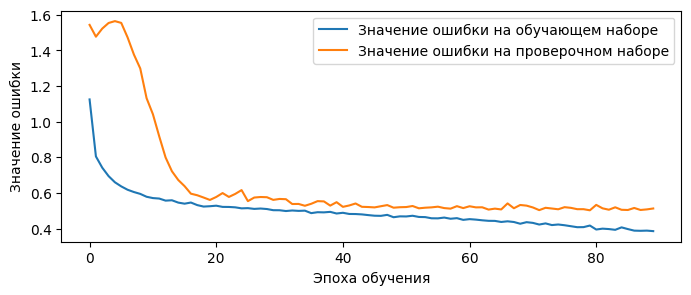

In [ ]:
# выведем график функции ошибки для обучающей и тестовой выборки
plt.figure(figsize = (8, 3))
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

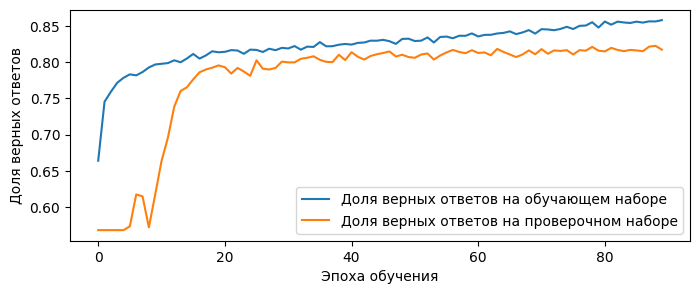

In [ ]:
# выведем график точности предсказаний на обучающем и тестовом наборе
plt.figure(figsize = (8, 3))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

90/90 [==============================] - 1s 6ms/step


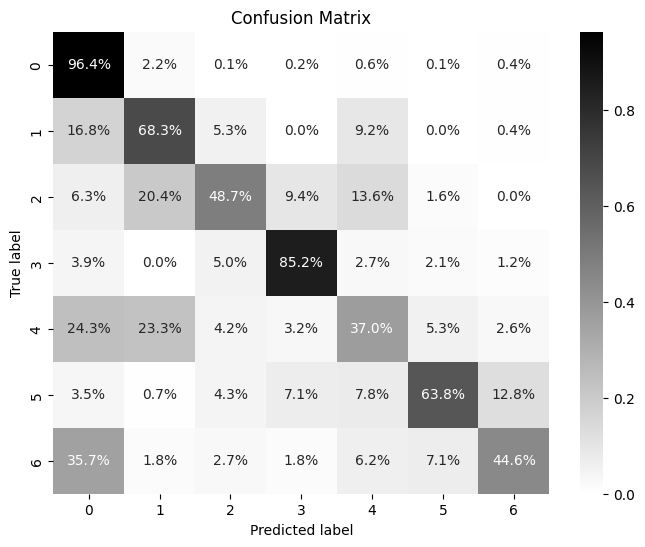

In [ ]:
# построим матрицу ошибок
#
Y_test_pred = model.predict(X_test)
Y_test_pred = np.argmax(Y_test_pred, axis=1)

# Создание матрицы ошибок
cm = confusion_matrix(Y_test, Y_test_pred)

# Преобразование значений матрицы ошибок в процентное соотношение
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1%", cmap='binary')

# Получение и подписывание классов
class_names = np.unique(Y_data)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names)
plt.yticks(tick_marks + 0.5, class_names)

# Добавление подписей к осям
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Показать график
plt.show()

In [ ]:
# vowel_codes = {'i': 1, 'e': 2, 'a': 3, 'y': 4, 'o': 5,'u': 6}

Анализ контекстов


In [ ]:
# восстановим контексты из закодированного вида
restored_contexts = list(le.inverse_transform(df['contexts']))
# print(restored_contexts[:10])
print(f'В корпусе всего {len(restored_contexts)} контекстов')

['_t', 'so0', 'ti4', 'o0t', 'i4e0', 'tt', 'e0e4', "tn'", 'e4i1', "n't"]
В корпусе всего 14268 контекстов


In [ ]:
# чтобы посмотреть, в каких местах ошибается модель, построим предсказание
Y_pred = model.predict(X_data)

446/446 [==============================] - 1s 2ms/step


In [ ]:
# посчитаем количество ошибочных контекстов
errors = []
for i, x in enumerate(Y_pred):
  predicted_value = np.argmax(x)
  if predicted_value != Y_data.to_numpy()[i]:
    errors.append(restored_contexts[i])

print('Всего ошибочных контекстов:', len(errors), '\nОшибочные контексты без повторов:', len(set(errors)))


Всего ошибочных контекстов: 6279 
Ошибочные контексты без повторов: 1167


In [ ]:
print(f'Из {len(set(restored_contexts))} контекстов ошибки встречаются в {len(set(errors))}')

Из 1887 контекстов ошибки встречаются в 1167


In [ ]:
# посчитаем контексты, в которых ошибки случались более 10 раз
repeated_errors = {}
for i, x in enumerate(errors):
  if errors.count(x) > 10:
    repeated_errors[x] = errors.count(x)
print(f'Чаще ошибки встречаются в {len(repeated_errors.keys())} контекстах')

Чаще ошибки встречаются в 165 контекстах


In [ ]:
repeated_errors

{'_t': 14,
 'o0t': 14,
 'tt': 26,
 "tn'": 18,
 "n't": 15,
 'dr': 14,
 't': 35,
 'mk': 15,
 'pl': 20,
 'tr': 32,
 'rs': 26,
 '_a0': 18,
 'kj': 13,
 'jv': 13,
 'rch': 14,
 "ns'": 20,
 'n': 80,
 "n'l": 12,
 'lp': 12,
 'ps': 13,
 '_a1': 20,
 'a0t': 12,
 'tn': 13,
 'dsh': 12,
 'kk': 25,
 'lk': 12,
 '_n': 22,
 'kz': 16,
 'tl': 19,
 'np': 32,
 'pd': 11,
 'dzh': 14,
 'dl': 16,
 'pk': 14,
 'rz': 18,
 'gv': 27,
 'vr': 14,
 'sm': 14,
 "n'": 22,
 'nch': 26,
 'nzh': 14,
 'bt': 12,
 'tm': 37,
 'chs': 34,
 'nd': 17,
 'dm': 13,
 "mt'": 20,
 "v't'": 14,
 "pn'": 14,
 "n'm": 26,
 'mj': 13,
 'j': 19,
 "m'n'": 24,
 "l'n": 64,
 'ns': 28,
 "s'l'": 13,
 'tj': 11,
 "chn'": 11,
 'rd': 14,
 "vr'": 19,
 'c': 16,
 "p'r": 12,
 'zhn': 21,
 'nl': 34,
 'lt': 15,
 'rv': 27,
 'zh': 11,
 'ng': 18,
 'nf': 12,
 'nm': 14,
 "r't'": 11,
 'vj': 17,
 'jm': 11,
 "m'": 14,
 'nj': 18,
 "n'k": 39,
 'v': 32,
 'jj': 14,
 "vl'": 14,
 'i4v': 19,
 "n'e4": 32,
 'tv': 23,
 "n'p": 14,
 '_o0': 12,
 'pch': 16,
 'rzh': 18,
 "zhn'": 14,
 "v'n"

In [ ]:
# посмотрим, есть ли специфичные для ошибок контексты
VV = 0
CC = 0
Cpal_Cpal = 0
C_Cpal = 0
Cpal_C = 0
CV = 0
# между мягким согласным и гласным
CV_pal = 0
B = 0
BV = 0
B_pal = 0
pal_B = 0

for x in repeated_errors.keys():
  # выделим контексты с гласными
  V_context = re.findall(r'[0-4]', x)
  if len(V_context) > 1:
    VV += 1
  elif len(V_context) == 1:
  # между гласным и мягким согласным
    if len(re.findall(r"'", x)) > 0:
      CV_pal += 1
  # между гласным и границей слова
    elif len(re.findall(r"_", x)) > 0:
      BV += 1
  # между гласным и твёрдым согласным
    else:
      CV += 1
  else:
    # проверим границу слова
    # после мягкого на конце слова
    if len(re.findall(r"'", x)) > 0 and x[-1] == "_":
      pal_B += 1
    # в начале слова перед мягким согласным
    elif len(re.findall(r"_", x)) > 0 and x[-1] == "'":
      B_pal += 1
    # в конце или начале слова рядом с твёрдым согласным
    elif len(re.findall(r"_", x)) > 0:
      B += 0
    else:
      # между мягкими
      if len(re.findall(r"'", x)) > 1:
        Cpal_Cpal += 1
      # перед мягким
      elif x[-1] == "'":
        C_Cpal += 1
      # после мягкого
      elif len(re.findall(r"'", x)) > 0:
        Cpal_C += 1
      # между твёрдыми
      else:
        CC += 1



print(f'Между гласными {VV}')
print(f'Между твёрдыми согласными {CC}')
print(f'Между мягкими согласными {Cpal_Cpal}')
print(f'После твёрдого и перед мягким согласными {C_Cpal}')
print(f'После мягкого и перед твёрдым {Cpal_C}')
print(f'Между гласным и согласным {CV}')
print(f'Между гласным и мягким согласным {CV_pal}')
print(f'На границе слова {B}')
print(f'Между гласным и границей слова {BV}')
print(f'В начале слова перед мягким согласным {B_pal}')
print(f'В конце слова после мягкого согласного {pal_B}')



Между гласными 0
Между твёрдыми согласными 97
Между мягкими согласными 9
После твёрдого и перед мягким согласными 22
После мягкого и перед твёрдым 23
Между гласным и согласным 6
Между гласным и мягким согласным 2
На границе слова 0
Между гласным и границей слова 4
В начале слова перед мягким согласным 0
В конце слова после мягкого согласного 0


In [ ]:
max_err = max(VV, CC, Cpal_Cpal, C_Cpal, Cpal_C, CV, CV_pal, B, BV, B_pal, pal_B) / len(repeated_errors.keys()) * 100
print(f'В {round(max_err, 2)}% процентах случаев ошибка в распознавании гласного возникает между твёрдыми согласными')

В 58.79% процентах случаев ошибка в распознавании гласного возникает между твёрдыми согласными
